In [0]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions.categorical import Categorical
from collections import namedtuple, deque
%config InlineBackend.figure_format = 'retina'

### Буффер

In [0]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
        self.Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'next_states', 'dones'))


    def push(self, *args):
        self.memory.append(self.Transition(*args))

    def sample(self, batch_size):
        batch = self.Transition(*zip(*random.sample(self.memory, batch_size)))

        return self.Transition(states=torch.FloatTensor(batch.states),
                               actions=torch.FloatTensor(batch.actions),
                               rewards=torch.FloatTensor(batch.rewards).unsqueeze(1),
                               next_states=torch.FloatTensor(batch.next_states),
                               dones=torch.FloatTensor(batch.dones).unsqueeze(1))

    def __len__(self):
        return len(self.memory)

### Нейронные сети для Актора и Критика

In [0]:
def weights_init_(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight, gain=1)
        torch.nn.init.constant_(layer.bias, 0)

class Critic(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Critic, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)

        self.linear4 = nn.Linear(input_dim, hidden_dim)
        self.linear5 = nn.Linear(hidden_dim, hidden_dim)
        self.linear6 = nn.Linear(hidden_dim, output_dim)

        self.apply(weights_init_)

    def forward(self, state):
        Q1 = F.relu(self.linear1(state))
        Q1 = F.relu(self.linear2(Q1))
        Q1 = self.linear3(Q1)

        Q2 = F.relu(self.linear4(state))
        Q2 = F.relu(self.linear5(Q2))
        Q2 = self.linear6(Q2)

        return Q1, Q2


class Actor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Actor, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        probs = F.softmax(self.linear3(x))
        return probs

    def sample(self, state):
        probs = self.forward(state)
        dist = Categorical(probs)
        action = dist.sample()
        z = probs == 0.0
        z = z.float() * 1e-8
        log_probs = torch.log(probs + z)
        return action, probs, log_probs

### SAC

In [0]:
class SAC_Discrete:

    def __init__(self):
        self.args = Parametrs()
        self.critic = Critic(self.args.state_dim, self.args.action_dim)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.args.lr_cr)
        self.critic_target = Critic(self.args.state_dim, self.args.action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor = Actor(self.args.state_dim, self.args.action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.args.lr_ac)

        self.log_alpha = torch.tensor(np.log(self.args.alpha), requires_grad=True)
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], lr=self.args.lr_alpha)

        self.memory = ReplayBuffer(capacity=self.args.buffer_size)
        self.updates = 0
        self.scores = []

    @property
    def alpha(self):
        return torch.exp(self.log_alpha)

    def act(self, state):
        state = torch.FloatTensor(state)
        with torch.no_grad():
            action, _, _ = self.actor.sample(state)
        return action.item()

    def update(self):
        if len(self.memory) < self.args.batch_size:
            return

        self.updates += 1
        state, action, reward, next_state, done = self.memory.sample(self.args.batch_size)
        action = action.unsqueeze(1)

        with torch.no_grad():
            next_action, next_probs, next_log_prob = self.actor.sample(next_state)
            Q1_next, Q2_next = self.critic_target(next_state)
            Q_next = next_probs * (torch.min(Q1_next, Q2_next) - self.alpha.detach() * next_log_prob)
            Q_next = Q_next.mean(dim=1).unsqueeze(-1)
            target = reward + (1 - done) * self.args.gamma * Q_next

        Q1, Q2 = self.critic(state)
        Q1_loss = F.mse_loss(Q1.gather(1, action.long()), target)
        Q2_loss = F.mse_loss(Q2.gather(1, action.long()), target)

        self.critic_optimizer.zero_grad()
        (Q1_loss + Q2_loss).backward()
        self.critic_optimizer.step()

        _, probs_new, log_prob_new = self.actor.sample(state)
        Q1_new, Q2_new = self.critic(state)
        Q = torch.min(Q1_new, Q2_new)
        
        policy_loss = (probs_new * ((self.alpha.detach() * log_prob_new) - Q)).mean()
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.update_alpha(probs_new, log_prob_new)
        if self.updates % self.args.upd_rate_crirtic == 0:
            self.soft_update()


    def update_alpha(self, prob, log_prob):
        loss = (prob.detach() * (self.alpha * (log_prob - self.args.desired_entropy).detach())).mean()
        self.log_alpha_optimizer.zero_grad()
        loss.backward()
        self.log_alpha_optimizer.step()

    def soft_update(self):
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.args.tau) + param.data * self.args.tau)


    def save(self, name):
        torch.save(self.actor.state_dict(), name)
        print('SAVE')

    def train(self):

        for episode in range(self.args.max_episodes):
            steps, total_reward, done, = 0, 0, False
            state = env.reset()

            while not done:
                if episode > self.args.exploration_episodes:
                    action = self.act(np.array(state))
                else:
                    action = env.action_space.sample()

                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                modified_reward = reward
                self.memory.push(state, action, modified_reward, next_state, int(done))
                self.update()
                state = next_state
                steps += 1
            self.scores.append(total_reward)
            if total_reward > self.args.reward_bound:
                test = self.test()
                if test > self.args.reward_bound:
                    break

            print(f'{total_reward}, steps: {steps} at episode {episode}')

    def test(self):
        env_new = gym.make(self.args.env_name)
        self.test_scores = []
        for i in range(100):
            state = env_new.reset()
            total_reward, steps = 0, 0
            done = False
            while not done:
                next_state, reward, done, _ = env_new.step(agent.act(state))
                total_reward += reward
                state = next_state
            self.test_scores.append(total_reward)
        return np.mean(self.test_scores)



### Отрисовка результатов

In [0]:
def plot_results(agent):
    plt.figure(figsize=(16, 16))
    ax1 = plt.subplot(421)
    ax2 = plt.subplot(422)
    ax1.plot(np.arange(0, len(agent.scores)), agent.scores)
    ax1.axvline(x=agent.args.exploration_episodes, color='g', linestyle='-.', label=f'exploration: {agent.args.exploration_episodes} episodes')
    ax1.set_title(f'Train')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.legend()

    ax2.plot(np.arange(0, len(agent.test_scores)), agent.test_scores)
    ax2.axhline(y=np.mean(agent.test_scores), color='r', linestyle='-', label=f'mean reward: {np.mean(agent.test_scores):2f}')
    ax2.set_title(f'Test')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Reward')
    ax2.legend()
    plt.show()

### Параметры обучения

In [23]:
class Parametrs:
    def __init__(self):
        self.env_name = "CartPole-v0"
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n

        self.gamma = 0.99
        self.tau = 0.05

        self.buffer_size = 5000
        self.batch_size = 256
        self.upd_rate_crirtic = 1
        self.desired_entropy = -self.action_dim

        self.lr_cr = 1e-3
        self.lr_ac = 1e-3
        self.lr_alpha = 1e-3

        self.alpha = 0.2
        self.max_episodes = 1000
        self.exploration_episodes = 100

        self.reward_bound = 199

env = gym.make("CartPole-v0")
agent = SAC_Discrete()
agent.train()

11.0, steps: 11 at episode 0
57.0, steps: 57 at episode 1
59.0, steps: 59 at episode 2
23.0, steps: 23 at episode 3
10.0, steps: 10 at episode 4
22.0, steps: 22 at episode 5
25.0, steps: 25 at episode 6
21.0, steps: 21 at episode 7
35.0, steps: 35 at episode 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


21.0, steps: 21 at episode 9
14.0, steps: 14 at episode 10
53.0, steps: 53 at episode 11
18.0, steps: 18 at episode 12
16.0, steps: 16 at episode 13
18.0, steps: 18 at episode 14
40.0, steps: 40 at episode 15
32.0, steps: 32 at episode 16
21.0, steps: 21 at episode 17
42.0, steps: 42 at episode 18
19.0, steps: 19 at episode 19
13.0, steps: 13 at episode 20
46.0, steps: 46 at episode 21
18.0, steps: 18 at episode 22
12.0, steps: 12 at episode 23
32.0, steps: 32 at episode 24
19.0, steps: 19 at episode 25
79.0, steps: 79 at episode 26
18.0, steps: 18 at episode 27
28.0, steps: 28 at episode 28
19.0, steps: 19 at episode 29
20.0, steps: 20 at episode 30
16.0, steps: 16 at episode 31
32.0, steps: 32 at episode 32
44.0, steps: 44 at episode 33
28.0, steps: 28 at episode 34
19.0, steps: 19 at episode 35
23.0, steps: 23 at episode 36
21.0, steps: 21 at episode 37
14.0, steps: 14 at episode 38
15.0, steps: 15 at episode 39
16.0, steps: 16 at episode 40
26.0, steps: 26 at episode 41
16.0, steps

In [27]:
agent.test_scores

[200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0]

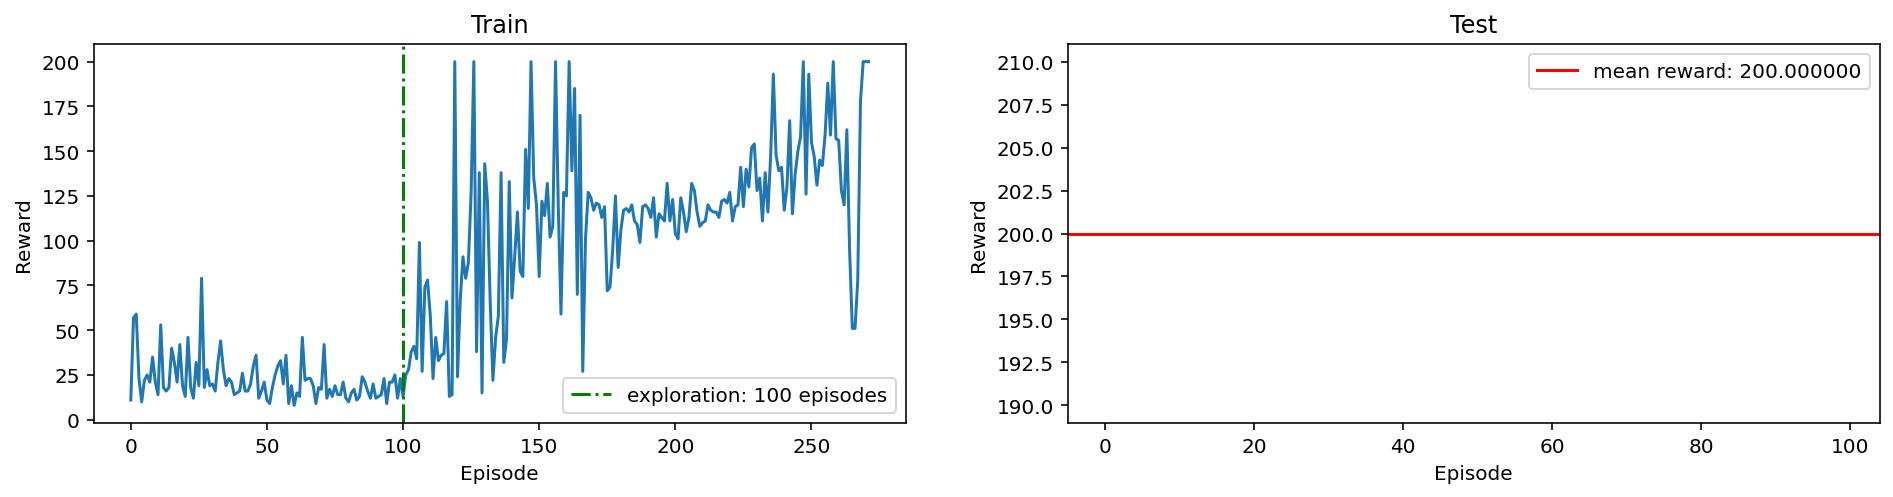

In [26]:
plot_results(agent)